In [1]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from SkeletonOfBeam import SkeletonOfBeam
from SkeletonOfBeam import GeometryToolBox

In [2]:
mesh = trimesh.load_mesh("cantilever.stl")

In [3]:
sob = SkeletonOfBeam(mesh, [1, 0, 0])
sob.getIntersections(step=1)
sp1 = sob.getSkeletonPoints()

In [4]:
sob.getNewCoordinate()

sob.getProjections()

sob.getSkeletonEqs()

sob.getDerivativeSkeletonEqs()

In [5]:
sp2 = sob.getNewSkeletonPoints()

In [6]:
sob.getNewIntersections()

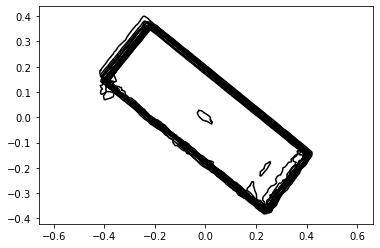

In [7]:
sob.showIntersections()

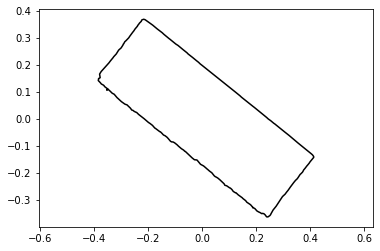

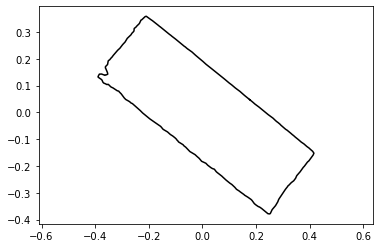

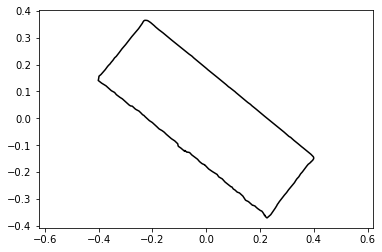

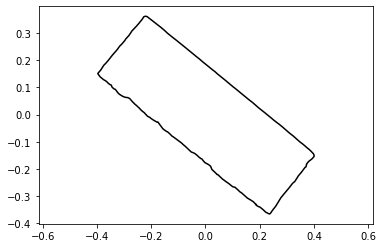

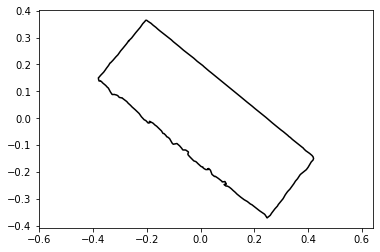

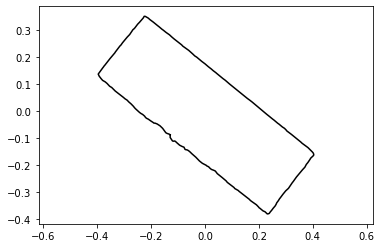

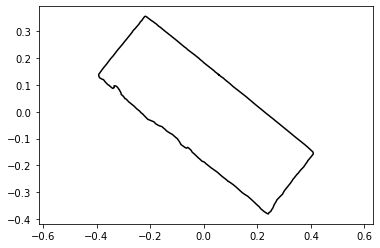

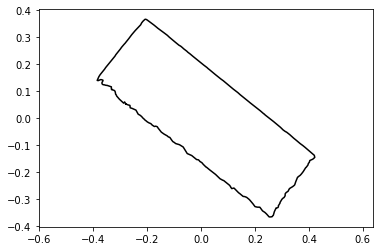

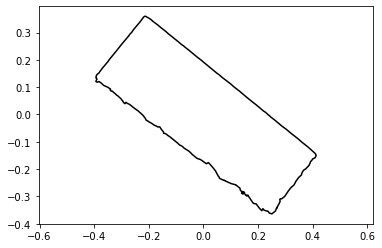

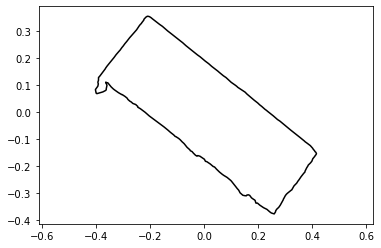

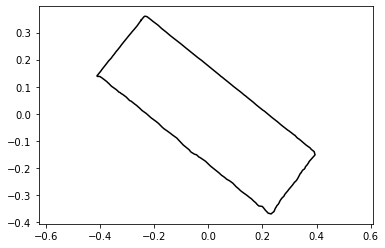

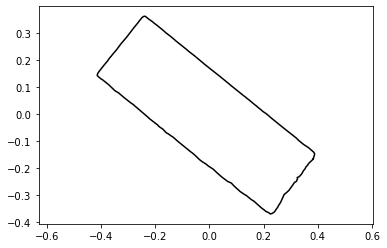

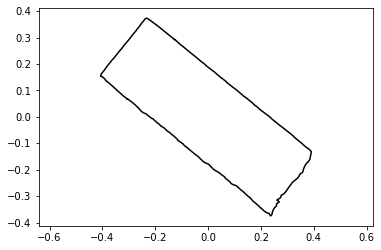

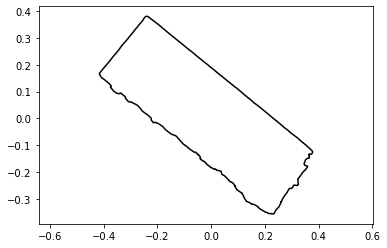

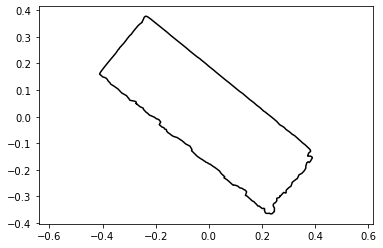

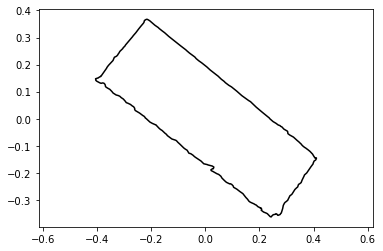

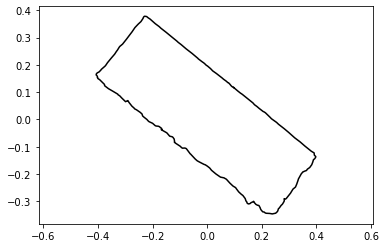

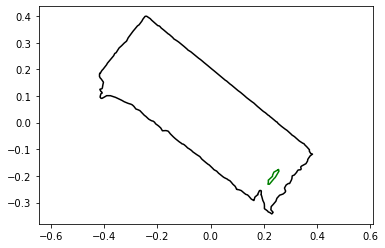

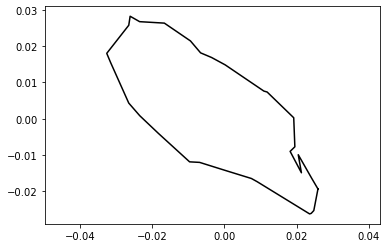

In [8]:
sob.showIntersections(ifOverlapped=False)

In [ ]:
combined = np.sum(c2s)
combined.show()

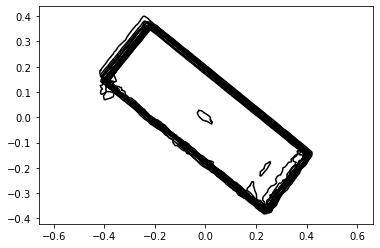

In [18]:
combined = np.sum(c2s)
combined.show()

In [13]:
np.array(sp1)

array([[-2.11987455e+01, -9.24698553e-01, -5.50272865e+00],
       [-2.01987455e+01, -9.46069017e-01, -5.54301441e+00],
       [-1.91987455e+01, -9.12249054e-01, -5.54710818e+00],
       [-1.81987455e+01, -8.76396648e-01, -5.55017508e+00],
       [-1.71987455e+01, -8.40930347e-01, -5.55418507e+00],
       [-1.61987455e+01, -8.01215409e-01, -5.55151074e+00],
       [-1.51987455e+01, -7.67933992e-01, -5.55119343e+00],
       [-1.41987455e+01, -7.32460694e-01, -5.55472407e+00],
       [-1.31987455e+01, -6.91348115e-01, -5.55732384e+00],
       [-1.21987455e+01, -6.49366174e-01, -5.54450340e+00],
       [-1.11987455e+01, -6.09103406e-01, -5.53520048e+00],
       [-1.01987455e+01, -5.68225372e-01, -5.52681111e+00],
       [-9.19874553e+00, -5.28119144e-01, -5.51537145e+00],
       [-8.19874553e+00, -4.85291627e-01, -5.50875926e+00],
       [-7.19874553e+00, -4.39418180e-01, -5.50185558e+00],
       [-6.19874553e+00, -3.94129700e-01, -5.49253697e+00],
       [-5.19874553e+00, -3.50620005e-01

In [7]:
np.array(sp2)

array([[0, -0.0227130547471558, -0.0227130547471558],
       [1.00000000000035, 0.00121043193351017, 0.00121043193351017],
       [2.00000000000034, 0.0273464748961918, 0.0273464748961918],
       [3.00000000000032, 0.0556141130789988, 0.0556141130789988],
       [4.00000000000030, 0.0859323854200338, 0.0859323854200338],
       [5.00000000000028, 0.118220330857398, 0.118220330857398],
       [6.00000000000021, 0.152396988329193, 0.152396988329193],
       [7.00000000000024, 0.188381396773525, 0.188381396773525],
       [8.00000000000021, 0.226092595128490, 0.226092595128490],
       [9.00000000000020, 0.265449622332194, 0.265449622332194],
       [10.0000000000002, 0.306371517322736, 0.306371517322736],
       [11.0000000000002, 0.348777319038221, 0.348777319038221],
       [12.0000000000002, 0.392586066416750, 0.392586066416750],
       [13.0000000000002, 0.437716798396424, 0.437716798396424],
       [14.0000000000002, 0.484088553915346, 0.484088553915346],
       [15.0000000000002, 

In [8]:
np.array(sp1) - np.array(sp2)

array([[-21.1987455294763, -0.901985498138482, -5.48001559290831],
       [-21.1987455294763, -0.947279448525519, -5.54422483855289],
       [-21.1987455294763, -0.939595529224096, -5.57445465648991],
       [-21.1987455294763, -0.932010760739092, -5.60578919255961],
       [-21.1987455294763, -0.926862732091125, -5.64011745898411],
       [-21.1987455294763, -0.919435739899355, -5.66973107071541],
       [-21.1987455294763, -0.920330980184141, -5.70359041631218],
       [-21.1987455294763, -0.920842090825330, -5.74310546464726],
       [-21.1987455294763, -0.917440709861000, -5.78341643819410],
       [-21.1987455294763, -0.914815796676860, -5.80995302692820],
       [-21.1987455294763, -0.915474922980870, -5.84157199331984],
       [-21.1987455294763, -0.917002691166597, -5.87558842694514],
       [-21.1987455294763, -0.920705210052652, -5.90795751243082],
       [-21.1987455294763, -0.923008425446660, -5.94647606083367],
       [-21.1987455294763, -0.923506733723095, -5.985944129968

In [13]:
a = np.array([1.1] * 6)
a = a.astype(np.int64)
a.dtype

dtype('int64')

In [25]:
sob.__H(1, 2)

AttributeError: 'SkeletonOfBeam' object has no attribute '__H'

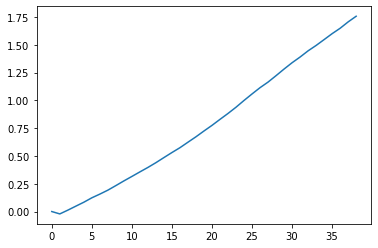

In [13]:
%matplotlib inline
plt.plot(np.array(sob.XYProjections)[:,0], np.array(sob.XYProjections)[:, 1])

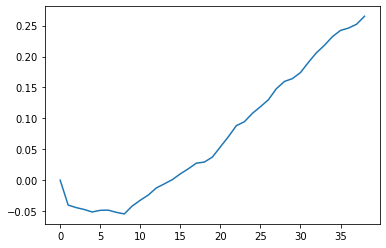

In [77]:
plt.plot(np.array(sob.XZProjections)[:,0], np.array(sob.XZProjections)[:, 1])

In [14]:
sob.returnTangentVectorAtXi(0.5)

TypeError: unsupported operand type(s) for -: 'int' and 'SkeletonOfBeam'

In [15]:
np.array(sob.XYProjections)[:,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.])

In [113]:
%matplotlib inline

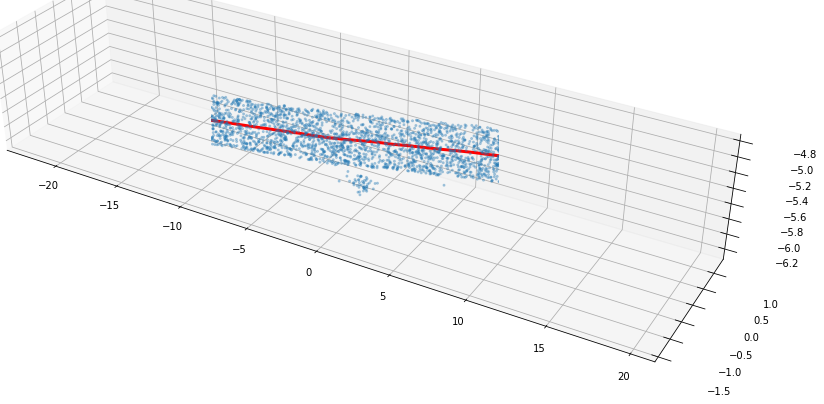

In [114]:
fig=plt.figure()

ax = Axes3D(fig)
x, y, z = np.array(mesh.vertices)[:, 0], np.array(mesh.vertices)[:, 1], np.array(mesh.vertices)[:, 2]
x = x[::100]
y = y[::100]
z = z[::100]

ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([4, 1, 1, 1]))
ax.scatter(x, y, z, alpha=0.3, s=4)
sx, sy, sz = np.array(sob.SkeletonPoints)[:, 0], np.array(sob.SkeletonPoints)[:, 1], np.array(sob.SkeletonPoints)[:, 2]

ax.plot(sx, sy, sz, color='red', linewidth=3)

In [ ]:
    T_location = Vector((1.0 , 0 ,.0))
    
    T_location_norm = T_location.copy()
    T_location_norm.normalize()
    originVector = Vector((.0 , .0 ,1.0))
    
        

    print(T_location_norm)
    // @是向量点乘
    sita = math.acos(T_location_norm@originVector)
    n_vector = T_location_norm.cross(originVector) 
    
    n_vector.normalize()
    
    n_vector_invert = Matrix((
    [0,-n_vector[2],n_vector[1]],
    [n_vector[2],0,-n_vector[0]],
    [-n_vector[1],n_vector[0],0]
    ))
    
    print(sita)
    print(n_vector_invert)
    
    
    I = Matrix((
    [1 ,  0 , 0],
    [0 ,  1 , 0],
    [0 ,  0 , 1]
    ))

    R_w2c = I + math.sin(sita)*n_vector_invert + n_vector_invert@(n_vector_invert)*(1-math.cos(sita))

In [21]:
slice = mesh.section(plane_origin=mesh.centroid, 
                 plane_normal=np.array([1, 0, 0]))
slice_2D, to_3D = slice.to_planar()
slice_firstPart = slice_2D.split()[0] # 分割，并选取第一个部分（应该是最大的那个部分）

In [22]:
print(slice)

<trimesh.Path3D(vertices.shape=(358, 3), len(entities)=2)>


In [54]:
slice_firstPart.to_3D(to_3D).centroid

array([-0.91451625, -0.13691134, -5.44386294])

In [4]:
mesh.bounds

array([[-21.28422928,  -1.49518299,  -6.24997091],
       [ 18.52413559,   1.31816697,  -4.69799995]])

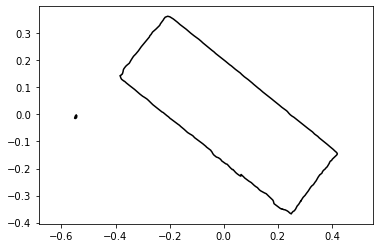

In [13]:
# get a single cross section of the mesh
slice = mesh.section(plane_origin=mesh.centroid, 
                     plane_normal=[1,0, 0])
slice_2D, to_3D = slice.to_planar()
slice_2D.show()

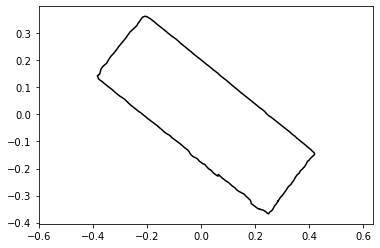

In [14]:
slices_splited = slice_2D.split()
sliceIndex = np.argmax([s.area for s in slices_splited])
slice_2D = slices_splited[sliceIndex]
slice_2D.show()

In [15]:
slice_2D.apply_obb()

array([[ 0.77499324, -0.63196952, -0.01554085],
       [ 0.63196952,  0.77499324, -0.00918349],
       [ 0.        ,  0.        ,  1.        ]])

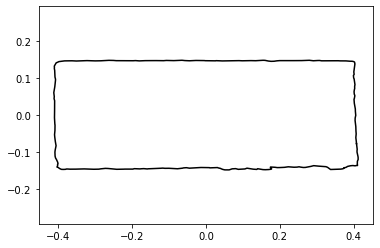

In [16]:
slice_2D.show()

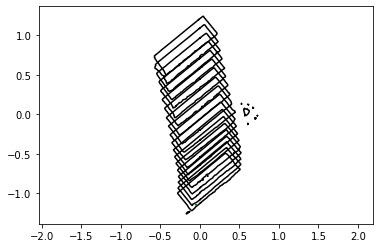

In [20]:
z_extents = mesh.bounds[:,0]
# slice every .125 model units (eg, inches)
z_levels  = np.arange(*z_extents, step=2)
sections = mesh.section_multiplane(plane_origin=mesh.centroid, 
                                   plane_normal=np.array([1, 0, 0]),
                                   heights=z_levels)

sections = [i for i in sections if i is not None]
combined = np.sum(sections)
combined.show()

In [20]:
import numpy as np


In [36]:
v1 = [1, 0, 0]
v2 = [0, 1, 0]

r = rotation_matrix(v1, v2)
r

array([[ 0., -1.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [37]:
np.dot(r, v1)

array([0., 1., 0.])

In [30]:
def projected_point(point, plane_origin, planeVec1, planeVec2):
    """
    已知平面内一原点以及两个正交向量，求已知点在该平面内的投影坐标（二维）
    """
    pVec = np.asarray(point) - np.asarray(plane_origin)
    xVec = np.asarray(planeVec1) / np.linalg.norm(planeVec1)
    yVec = np.asarray(planeVec2) / np.linalg.norm(planeVec2)
    s1 = np.dot(pVec, xVec)
    s2 = np.dot(pVec, yVec)
    
    return np.array([s1, s2])

In [29]:
p = [1, 1, 5]
o = [0, 0, 0]
x = [1, 1, 0]
y = [-1, 1, 0]
projected_point(p, o, x, y)

array([1.41421356, 0.        ])

In [19]:
np.dot(r, v1)

array([0., 1., 0.])

In [14]:
np.arccos(np.dot([0, 1, 0], [1, 0, 0]))

1.5707963267948966

In [15]:
np.pi/2

1.5707963267948966

In [16]:
np.linalg.norm([1, 0, 0])

1.0